### Try to build our own NDE, not conditioned on anything. Only work on magnitudes.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn, Tensor, optim
import pickle
import matplotlib.pyplot as plt
import numpy as np
import corner
from tqdm import trange

In [3]:
import os
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, Photulator, StandardScaler

In [ ]:
## Load the NN emulator for mags: `Photulator`
with open('./phot_best_loss_model.pkl', 'rb') as f:
    photulator = pickle.load(f)

In [4]:
flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])
zero_flag = (np.mean(np.load('./train_sed/log_spec_all.npy'), axis=1) < -30)
# log_spec_all = np.load('./train_sed/log_spec_all.npy')[~zero_flag]
phot_all = np.load('./train_sed/phot_all.npy')[~zero_flag]
params = np.load('./train_sed/param_all.npy')[:, ~flag][~zero_flag]

In [ ]:
y_test = np.random.multivariate_normal(mean=[6, 0], cov=[[0.5, 0.3], [0.3, 0.1]], size=2000)
y_test = Tensor(y_test)
x_test = photulator.predict_mag(y_test).cpu().detach().numpy()
x_test = Tensor(x_test).to('cuda')

figure = corner.corner(y_test.cpu().detach().numpy(), quantiles=[0.16, 0.5, 0.84], 
                       labels=['tage', 'log tau'],
                       show_titles=True, title_kwargs={"fontsize": 12})

In [47]:
mag_all = -2.5 * np.log10(phot_all).astype('float32')
d = 5
mag_all.shape

(1560, 5)

In [48]:
mag_test = np.copy(mag_all)

In [6]:
# Try faiss

In [49]:
import faiss
# import faiss.contrib.torch_utils # enable torch tensor

In [50]:
index = faiss.IndexFlatL2(d)   # build the index
print(index.is_trained)
index.add(mag_all)                  # add vectors to the index
print(index.ntotal)

True
1560


In [52]:
k = 5                        # we want to see 4 nearest neighbors
D, I = index.search(mag_test[:5], k) # sanity check
print(I)
print(D)

[[0 1 2 3 4]
 [1 0 2 3 4]
 [2 1 3 0 4]
 [3 2 4 1 0]
 [4 3 5 2 1]]
[[0.0000000e+00 1.6819293e-05 8.6173546e-05 2.5027434e-04 5.7954132e-04]
 [0.0000000e+00 1.6819293e-05 2.6851660e-05 1.3733575e-04 3.9893063e-04]
 [0.0000000e+00 2.6851660e-05 4.2736021e-05 8.6173546e-05 2.1881438e-04]
 [0.0000000e+00 4.2736021e-05 6.8167239e-05 1.3733575e-04 2.5027434e-04]
 [0.0000000e+00 6.8167239e-05 1.0873887e-04 2.1881438e-04 3.9893063e-04]]


In [10]:
from sklearn.neighbors import NearestNeighbors

In [35]:
NN_X = NearestNeighbors(n_neighbors=5).fit(mag_all)

In [39]:
sk_d, sk_i = NN_X.kneighbors(mag_all[:10], n_neighbors=5)

In [40]:
sk_i

array([[ 0,  1,  2,  3,  4],
       [ 1,  0,  2,  3,  4],
       [ 2,  1,  3,  0,  4],
       [ 3,  2,  4,  1,  0],
       [ 4,  3,  5,  2,  1],
       [ 5,  4,  6,  3,  2],
       [ 6,  5,  7,  4,  3],
       [ 7,  6,  8,  5,  4],
       [ 8,  7,  9,  6,  5],
       [ 9,  8, 10,  7,  6]])

In [41]:
I == sk_i

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

### First, we fit a NDE to `x_test`

In [8]:
from popsed.nde import NeuralDensityEstimator

In [81]:
NDE = NeuralDensityEstimator(method='nsf')
NDE.build(x_test, optimizer='adam')

Training NDE: 100%|██████████████████████████████████████████████████████████████████| 4000/4000 [03:14<00:00, 20.53epochs/s]


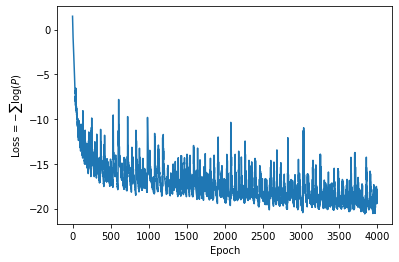

In [83]:
NDE.train(n_epochs=4000, display=True)

In [9]:
with open('./best_loss_model_nde_nsf.pkl', 'rb') as f:
    NDE = pickle.load(f)

In [10]:
samples = NDE.sample(2000)

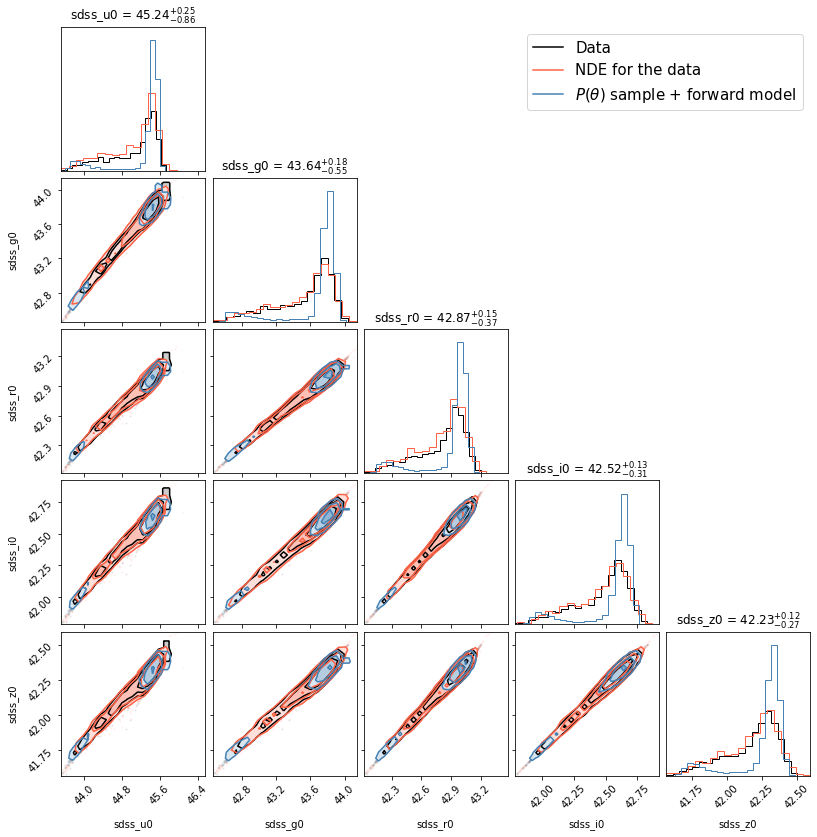

In [146]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='steelblue', label=r'$P(\theta)$ sample + forward model')

labels = [f'sdss_{f}0' for f in 'ugriz']

figure = corner.corner(x_test.cpu().detach().numpy(), 
                       color='k', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.5, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12})

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels,
                  color='tomato', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=False, title_kwargs={"fontsize": 12})

nf_plot = corner.corner(photulator.predict_mag(NDE_theta.sample(2000)).cpu().detach().numpy(), 
                  fig=figure, labels=labels,
                  color='steelblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=False, title_kwargs={"fontsize": 12})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, r_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

$P(x|\theta)$

### Second, we try to achieve our goal, with loss = NDE.log_prob(X), where X is the model output.

In [141]:
NDE_theta = NeuralDensityEstimator(method='maf')
NDE_theta.build(y_test, optimizer='adam')

In [128]:
# from scipy.stats import entropy

In [129]:
# test = photulator.predict_mag(NDE_theta.sample(2000)).cpu().detach().numpy()

In [130]:
# %%time
# torch.autograd.functional.jacobian(photulator.network, y_test.to('cuda'))

In [131]:
# KL_w2009_eq29(NDE.sample(2000), photulator.predict_mag(NDE_theta.sample(2000)), silent=False)

In [136]:
std = torch.cov(photulator.predict_mag(NDE_theta.sample(2000))).norm()

tensor(3090.9858, device='cuda:0', grad_fn=<CopyBackwards>)

In [143]:
for epoch in trange(1000, desc='Training NDE_theta', unit='epochs'):
    NDE_theta.optimizer.zero_grad()
    # loss = KL_w2009_eq29(NDE.sample(2000), photulator.predict_mag(NDE_theta.sample(2000)))
    std = torch.std(photulator.predict_mag(NDE_theta.sample(2000)), axis=0).mean()
    loss = -NDE.net.log_prob(photulator.predict_mag(NDE_theta.sample(2000))).nanmean() - torch.log(std)
    # Log(P) loss is wrong in this case.
    loss.backward()
    NDE_theta.optimizer.step()
    NDE_theta.train_loss_history.append(loss.item())
#     if loss.item() < -19:
#         break

Training NDE_theta: 100%|████████████████████████████████████████████████████████████| 1000/1000 [01:20<00:00, 12.37epochs/s]


In [23]:
from popsed.nde import KL_w2009_eq29

In [28]:
KL_w2009_eq29(-2.5 * np.log10(phot_all), photulator.predict_mag(NDE_theta.sample(2000)).cpu().detach().numpy())

  epsilons  [1.30764008 1.30824714 1.30904263 ... 0.16148892 0.15581812 0.15438161]
  l_i  [378 378 381 ...  50  48  53]
  k_i  [1 1 1 ... 1 1 1]
  first term = 0.072403
  digamma term = 4.830378


5.151884295360714

In [16]:
photulator.predict_mag(NDE_theta.sample(2000))

tensor([[45.4832, 43.8423, 43.0448, 42.6832, 42.3729],
        [45.4306, 43.7688, 42.9671, 42.6041, 42.2979],
        [45.5283, 43.8620, 43.0503, 42.6856, 42.3740],
        ...,
        [45.4188, 43.7581, 42.9577, 42.5953, 42.2896],
        [45.5562, 43.8833, 43.0670, 42.7004, 42.3876],
        [45.5710, 43.8960, 43.0780, 42.7107, 42.3971]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [17]:
NDE.net.log_prob(photulator.predict_mag(NDE_theta.sample(2000))).nanmean()

tensor(22.3352, device='cuda:0', grad_fn=<DivBackward0>)

In [18]:
NDE.net.log_prob(NDE.sample(20000)).nanmean()

tensor(19.1063, device='cuda:0', grad_fn=<DivBackward0>)

In [19]:
-NDE.net.log_prob(photulator.predict_mag(NDE_theta.sample(2000))).nanmean()

tensor(-22.3498, device='cuda:0', grad_fn=<NegBackward0>)

(-30.0, 0.0)

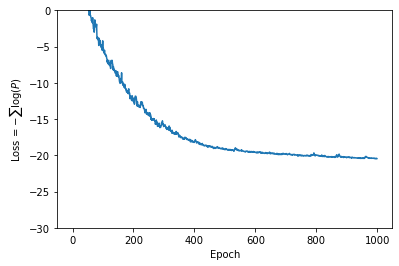

In [144]:
NDE_theta.plot_loss()
plt.ylim(-30, 0)

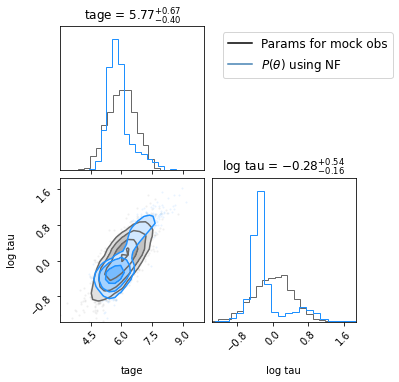

In [145]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'$P(\theta)$ using NF')

labels = ['tage', 'log tau']

figure = corner.corner(y_test.cpu().detach().numpy(), 
                       color='dimgray', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.7, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12})

nf_plot = corner.corner(NDE_theta.sample(2000).cpu().detach().numpy(), 
                  fig=figure, labels=labels,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.7, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=12, bbox_to_anchor=(0., 1.0, 1.3, .0))